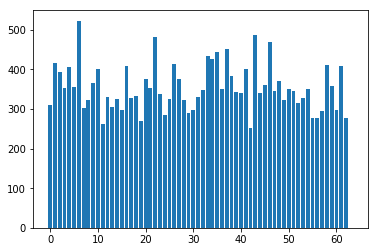

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
done in 2.3367068767547607 s


In [1]:
from operator import itemgetter
import numpy
import winsound
import time
import matplotlib.pyplot as plt


# Turn string MMMMIMMD... into 4M1I2M1D...
def compress_letters(word):
    res = ""
    
    cur_let = word[0]
    cur_cnt = 1
    for i in range(1, len(word)):
        if word[i] == cur_let:
            cur_cnt += 1
        else:
            res += str(cur_cnt) + cur_let
            cur_let = word[i]
            cur_cnt = 1
            
    res += str(cur_cnt) + cur_let
    
    return res
   

# Scoring matrix for dynamic programming
def scoringMatrix(a,b):
    if a==b: return 1
    if a=='_' or b=='_': return -7
    maxb, minb = max(a,b), min(a,b)
    if minb=='A' and maxb=='G': return -1
    if minb=='C' and maxb=='T': return -1
    return -3


# Global alignment of two strings
def globalAlignment(x,y, s):
    D = numpy.zeros((len(x)+1,len(y)+1), dtype=int)

    for i in range(1, len(x)+1):
        D[i,0]=D[i-1,0]+s(x[i-1],'_')  
    for j in range(1, len(y)+1):
        D[0,j]=D[0,j-1]+s('_',y[j-1]) # D[0,j]=D[0,j-1]+s('_',y[i-1])

    for i in range(1,len(x)+1):
        for j in range(1,len(y)+1):
            D[i,j]=max(D[i-1,j]  +s(x[i-1], '_'),
                       D[i,j-1]  +s('_',   y[j-1]), 
                       D[i-1,j-1]+s(x[i-1],y[j-1]))

    # function returns table and global alignment score
    #alignment score is in cell (n,m) of the matrix
    return D, D[len(x),len(y)]
    

# Traceback through dynamic programming matrix
def traceback(x,y,V,s):
    # initializing starting position cell(n,m)
    i=len(x)
    j=len(y)

    # initializing strings we use to represent alignments in x, y, edit transcript and global alignment
    ax,ay,am, tr = '','','',''

    # exit condition is when we reach cell (0,0)
    while (i>0 or j>0):
        # calculating diagonal, horizontal and vertical scores for current cell
        if i>0 and j>0:
            sigma = 1 if x[i-1]==y[j-1] else 0
            d = V[i-1,j-1] + s(x[i-1],y[j-1])  # diagonal movement   
        if i>0 : v = V[i-1,j] + s(x[i-1],'_')  # vertical movement
        if j>0 : h = V[i,j-1] + s('_',y[j-1])  # horizontal movement

        # backtracing to next(previous) cell
        if d>=v and d>=h:
            ax+=x[i-1]
            ay+=y[j-1]
            if sigma==1:
                tr+='M'
                am+='|'
            else:
                tr+='R'
                am+=' '
            i-=1
            j-=1
        elif v>=h:
            ax+=x[i-1]
            ay+='_'
            tr+='I'
            am+=' '
            i-=1
        else:
            ay+=y[j-1]
            ax+='_'
            tr+='D'
            am+=' '
            j-=1

    alignment='\n'.join([ax[::-1][0:50], am[::-1][0:50], ay[::-1][0:50]])
    return alignment, tr[::-1]


# Index structure, hash map
class IndexHash(object):
    
    def __init__(self, t, ln):
        """ Create index, extracting substrings of length 'ln' """
        self.t = t
        self.ln = ln
        self.index = {}
        for i in range(len(t) - ln + 1):
            substr = t[i: i + ln]
            if substr in self.index:
                self.index[substr].append(i) # substring already in dictionary
            else:
                self.index[substr] = [i] # add to dictionary
    
    def query(self, p):
        """ Return candidate alignments for p """
        return self.index.get(p[:self.ln], [])

    
# Make a complement from the argument string
def make_strand_complement(strand):
    complements = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
    return ''.join([complements.get(base, base) for base in strand.upper()[::-1]])      


# Class for alignment
class CustomAligner(object):
    
    def __init__(self, fasta_fp, fastq_fp, seed_ln, seed_int):
        self.fasta_filepath = fasta_fp
        self.fastq_filepath = fastq_fp
        self.seed_length = seed_ln
        self.seed_interval = seed_int
        self.seed_win_size = 300 # default
        self.fasta_name = ""
        self.fasta_sequence = ""
        self.read_entries = dict()
        self.seed_windows = dict()

    # Read fasta file and save sequence value 
    def parse_fasta(self):
        with open(self.fasta_filepath) as f:
            self.fasta_name = f.readline().rstrip()[1:]
            self.fasta_sequence = f.readline().rstrip()
        
        for i in range(100, 300):
            if len(self.fasta_sequence) % i == 0:
                self.seed_win_size = i
                break
        
    # Read fastq file and save reads in a dict: read_name -> (read, read_complement)
    def parse_fastq(self):
        with open(self.fastq_filepath) as f:
            line = f.readline().rstrip()
            while line:
                if line.startswith("@") or line.startswith("+"):
                    prev = line[0]
                    if line.startswith("@"):
                        name = line[1:].split("/")[0]
                else:
                    if prev.startswith("@"):
                        strand = line
                    elif prev.startswith("+"):
                        self.read_entries[name] = dict()
                        self.read_entries[name]["strand"] = strand
                        self.read_entries[name]["reverse_strand"] = make_strand_complement(strand)
                        self.read_entries[name]["strand_quality"] = line
                        self.read_entries[name]["blocks"] = list()
                        self.read_entries[name]["fasta_name"] = self.fasta_name
                        self.read_entries[name]["positions_in_ref"] = list()
                        self.read_entries[name]["cigars"] = list()
                        self.read_entries[name]["flags"] = 4 # Default unmapped

                line = f.readline().rstrip()
          
    # Make seeds from given read and save info
    def align_seeds_from_read(self, read_string, index):
        seed_info = list()
        for i in range (0, len(read_string), self.seed_interval):
            end = min(len(read_string), i + self.seed_length)
            cur_seed = read_string[i: end]
            positions_list = index.query(cur_seed)
            if len(positions_list) > 0:
                seed_info.append((positions_list, i, end))
        
        return seed_info
    
    # Split each read into seeds, and save info of it 
    def make_seeds(self, index_forward, index_reverse):
        # (list_of_positions_in_ref, start_pos_in_read, end_pos_in_read)
        for key, value in self.read_entries.items():
            tmp_lists = list()
            tmp_lists.append(self.align_seeds_from_read(value["strand"], index_forward))
            #tmp_lists.append(self.align_seeds_from_read(value[0], index_reverse))
            tmp_lists.append(self.align_seeds_from_read(value["reverse_strand"], index_forward))
            #tmp_lists.append(self.align_seeds_from_read(value[1], index_reverse))
            max_len, max_list, max_ind = max((len(x), x, tmp_lists.index(x)) for x in tmp_lists)
            
            if max_len != 0:
                self.read_entries[key]["flags"] = max_ind
            
            for seed_entry in max_list:
                for position in seed_entry[0]:
                    block_entry = dict()
                    block_entry["pos_ref"] = int(position)
                    block_entry["start_read"] = seed_entry[1]
                    block_entry["end_read"] = seed_entry[2]
                    
                    win_key = int(position / self.seed_win_size)
                    if win_key in self.seed_windows:
                        self.seed_windows[win_key] += 1
                    else:
                        self.seed_windows[win_key] = 1
                    self.read_entries[key]["blocks"].append(block_entry)
       
    # Merge seeds where can be merged
    def merge_seeds(self):
        # Merge seeds within a read
        for key in self.read_entries:
            self.read_entries[key]["blocks"] = sorted(self.read_entries[key]["blocks"], key = itemgetter("pos_ref"))
            if len(self.read_entries[key]["blocks"]) > 0:
                prev_block = self.read_entries[key]["blocks"][0]
                i = 1
                while i < len(self.read_entries[key]["blocks"]):
                    if prev_block["end_read"] >= self.read_entries[key]["blocks"][i]["start_read"] and \
                    prev_block["pos_ref"] + prev_block["end_read"] - prev_block["start_read"] >= \
                    self.read_entries[key]["blocks"][i]["pos_ref"] and \
                    prev_block["pos_ref"] + prev_block["end_read"] - prev_block["start_read"] <= len(self.fasta_sequence):
                        self.read_entries[key]["blocks"][i - 1]["end_read"] = max(self.read_entries[key]["blocks"][i - 1]["end_read"],
                                                                                  self.read_entries[key]["blocks"][i]["end_read"])
                        self.read_entries[key]["blocks"].remove(self.read_entries[key]["blocks"][i])
                        prev_block = self.read_entries[key]["blocks"][i - 1]
                    else:
                        prev_block = self.read_entries[key]["blocks"][i]
                        i += 1
           
    # Perform seed
    def seed(self):
        index_forward = IndexHash(self.fasta_sequence, self.seed_length)
        index_reverse = IndexHash(make_strand_complement(self.fasta_sequence), self.seed_length)
        
        self.make_seeds(index_forward, index_reverse)
        
        for i in range(int(len(self.fasta_sequence) / self.seed_win_size) + 1):
            if i not in self.seed_windows:
                self.seed_windows[i] = 0
                
        plt.bar(list(self.seed_windows.keys()), list(self.seed_windows.values()))
        plt.show()
            
        self.merge_seeds()
    
    # Do dynamic programming over defined read
    def dyn_prog(self, read_key, read_start, pos_in_ref):
        value = self.read_entries[read_key]
        
        soft_clip_start = ""
        soft_clip_end = ""

        y = value["strand"] if value["flags"] == 0 else value["reverse_strand"]

        start_ref = pos_in_ref - read_start
        if start_ref < 0:
            start_ref = 0
            soft_clip_start = str(abs(pos_in_ref - read_start)) + "S"

        end_ref = start_ref + len(value["strand"])
        if end_ref > len(self.fasta_sequence):
            end_ref = len(self.fasta_sequence)
            soft_clip_end = str(start_ref + len(value["strand"]) - len(self.fasta_sequence)) + "S"
            y = y[:end_ref - start_ref]

        x = self.fasta_sequence[start_ref: end_ref]

        D, alignment_score = globalAlignment(x, y, scoringMatrix)
        alignment, transcript = traceback(x,y, D, scoringMatrix)
        
        return alignment_score, soft_clip_start + compress_letters(transcript) + soft_clip_end, start_ref
    
    # Adding info about reads
    def add_info(self, read_key, start_ref, alignment_score, transcript):
        self.read_entries[read_key]["positions_in_ref"].append(start_ref)
        self.read_entries[read_key]["map_qual"] = alignment_score
        self.read_entries[read_key]["cigars"].append(transcript)
    
    # Wrapping functions
    def dyn_pr_add_info(self, read_key, read_start, pos_in_ref):
        alignment_score, transcript, start_ref = self.dyn_prog(read_key, read_start, pos_in_ref)
        self.add_info(read_key, start_ref, alignment_score, transcript)
    
    def find_best_candidate(self, read_key):
        blocks = self.read_entries[read_key]["blocks"]
        blocks_ranking = dict()
        for i in range(len(blocks)):
            block = blocks[i]
            pos = block["pos_ref"] + int((block["end_read"] - block["start_read"]) / 2)
            blocks_ranking[i] = self.seed_windows[int(pos / self.seed_win_size)]
            
        blocks_ranking = sorted(blocks_ranking.items(), key=itemgetter(1))[::-1]
        #print(blocks_ranking)
        candidates = blocks_ranking[0: min(3, len(blocks_ranking))]
        best_cand = 0
        best_tuple = (-100000, "", 0)
        for cand in candidates:
            (alignment_score, transcript, start_ref) = self.dyn_prog(read_key, blocks[cand[0]]["start_read"], \
                                                                    blocks[cand[0]]["pos_ref"])
            if alignment_score > best_tuple[0]:
                best_tuple = (alignment_score, transcript, start_ref)
                best_cand = cand
        
        self.add_info(read_key, best_tuple[2], best_tuple[0], best_tuple[1])
    
    def extend(self):
        c = 0
        for key, value in self.read_entries.items():
            c += 1
            if c % 100 == 0:
                print(c)
                
            blocks = value["blocks"]
            n_bl = len(blocks)
            strand_len = len(value["strand"])
            
            # Unmapped
            if n_bl == 0:
                self.add_info(key, 0, 0, "*")
            else:
                # One block in read, save if completely aligned, do dynamic programming if not
                if n_bl == 1:
                    if blocks[0]["start_read"] == 0 and blocks[0]["end_read"] == len(value["strand"]):
                        self.add_info(key, blocks[0]["pos_ref"], strand_len, str(strand_len) + "M")
                    else:
                        self.dyn_pr_add_info(key, blocks[0]["start_read"], blocks[0]["pos_ref"])
                else:
                    # Two or more blocks in read, if diff between first and last block is acceptable, do dyn prog
                    if (blocks[n_bl - 1]["pos_ref"] + blocks[n_bl - 1]["end_read"] - blocks[n_bl - 1]["start_read"]) - \
                    (blocks[0]["pos_ref"] - blocks[0]["start_read"]) <= len(value["strand"]) + 10:
                        self.dyn_pr_add_info(key, blocks[0]["start_read"], blocks[n_bl - 1]["pos_ref"])
                    else:
                        # If there are edging blocks 
                        if blocks[0]["pos_ref"] <= len(value["strand"]) and \
                        blocks[n_bl - 1]["pos_ref"] >= len(self.fasta_sequence) - len(value["strand"]):
                            self.dyn_pr_add_info(key, blocks[0]["start_read"], blocks[0]["pos_ref"])
                            self.dyn_pr_add_info(key, blocks[n_bl - 1]["start_read"], blocks[n_bl - 1]["pos_ref"])
                        else:
                            self.find_best_candidate(key)
        
    def save_to_file(self, filepath):
        with open(filepath, 'w') as file:
            for key, value in self.read_entries.items():
                for i in range (len(value["positions_in_ref"])):
                #for pos in value["positions_in_ref"]:
                    file.write(key + "\t" + str(value["flags"]) + "\t" + str(value["fasta_name"]) + "\t" +
                               str(value["positions_in_ref"][i]) + "\t" + str(value["map_qual"]) + "\t" +
                               str(value["cigars"][i]) + "\t" + str(value["strand"]) + "\t" +
                               str(value["reverse_strand"]) + "\n")

# Program
start_time = time.time()
#fastq_filepath = "data/test.fq"
fastq_filepath = "../data/art.fq"
ca = CustomAligner("../data/MT.fa", fastq_filepath, 20, 10)
ca.parse_fasta()
ca.parse_fastq()
ca.seed()
ca.extend()
ca.save_to_file(fastq_filepath + ".samalike")

print("done in " + str(time.time() - start_time) + " s")
winsound.PlaySound("*", winsound.SND_ALIAS)